# Alternative background model

Here we explore an alternative way of modeling background emissions. 
In stead of mapping 2D image to 1D using $x = \cos(\mathrm{sza})/\cos(\mathrm{dza})$ as demonstrated in 001_background_removal, we use B-splines defined on a sphere.

The method works as follows:
- Images are first converted into "solar zenith angle" coordinates, with the north pole at the subsolar point (slat=90) and the south pole at the anti-subsolar point (slat = -90). The prime meridian is the meridian crossing the geograpic north pole.
- The background level of the images are identified as the median of non-dayglow pixels and substracted.
- The intensities are corrected for viewing angle using $I = I_0 \cos(\mathrm{dza}) / \exp(c(1 - 1/\cos(\mathrm{dza})))$, where  $\cos(\mathrm{dza})$ accounts for the increase in emissions and $\exp(c(1 - 1/\cos(\mathrm{dza})))$ accounts for the increase in absorption with vieving angle. The constant $c$ must be determined a-priori (see below).
- A model of the intensity is then $I = \sum_{i=1}^{I} \sum_{j=1}^{J} \sum_{k=1}^{K} a_{ijk} B_i(\mathrm{slat})B_j(\mathrm{slon})B_k(\mathrm{time})$ , where $B_i$, $B_j$ and $B_k$ are B-splines defines by an order and knot locations. The longitudinal B-spline is periodic.
- The model coefficients $a_{ijk}$ are found by robustly solving the (regularized) inverse problem


Import packages and the sample Dataset

In [1]:
# Imports
import fuvpy as fuv
import numpy as np
import glob
import warnings
import matplotlib.pyplot as plt
from polplot import pp
warnings.filterwarnings("ignore",category =RuntimeWarning) # Turn of all the warnings when np.where contains NaNs. 

In [2]:
path = '../sample_wicfiles/'
wicfiles = glob.glob(path + '*.idl')
wic = fuv.read_idl(wicfiles,dzalim=75)

Make and display the spherical B-spline (SBS) model

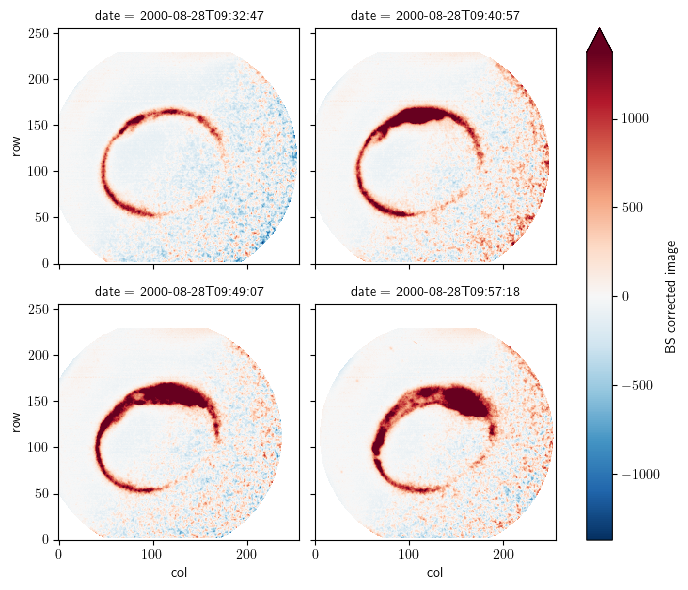

In [3]:
wic = fuv.backgroundmodel_SBS(wic,tOrder=0,dzacorr=0.15,tukeyVal=2,dampingVal=0e10)
wic.isel(date=[2,6,10,14])['dgimg'].plot(x='col', y='row', col='date', col_wrap=2,robust=True)

Here is the result in a polar projection, which can be compared to the results in 001_background_removal

Text(0.5, 1.0, 'Corrected image')

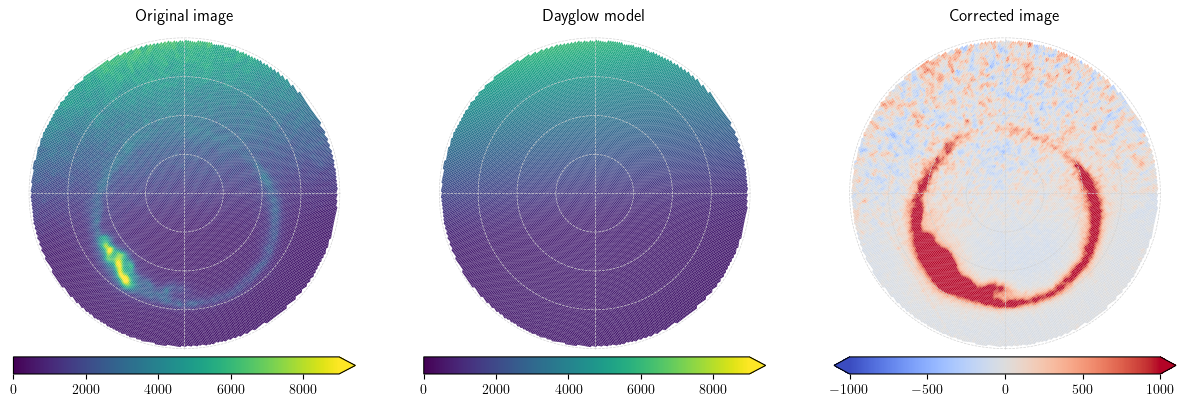

In [4]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
wic.isel(date=6).fuv.plotimg('img',pax=pp(axs[0]),crange=(0,9000))

wic.isel(date=6).fuv.plotimg('dgmodel',pax=pp(axs[1]),crange=(0,9000))
wic.isel(date=6).fuv.plotimg('dgimg',pax=pp(axs[2]),crange=(-1000,1000),cmap='coolwarm')

cbar = plt.colorbar(axs[0].collections[0],orientation='horizontal',ax=axs[0],extend='max',pad=0)
axs[0].set_title('Original image')

cbar = plt.colorbar(axs[1].collections[0],orientation='horizontal',ax=axs[1],extend='max',pad=0)
axs[1].set_title('Dayglow model')

cbar = plt.colorbar(axs[2].collections[0],orientation='horizontal',ax=axs[2],extend='both',pad=0)
axs[2].set_title('Corrected image')

To further examine the performance of the SBS background model, we plot the background corrected counts (model misfit) vs solar zenith angle and the observed vs modelled counts:

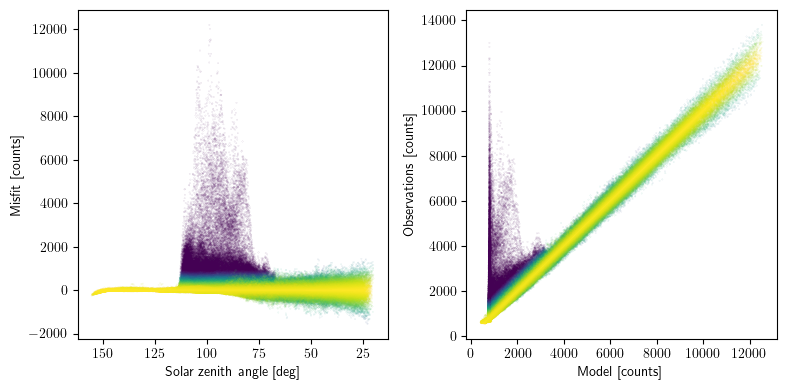

In [5]:
fig,axs = plt.subplots(1,2,figsize=(8,4))
axs[0].scatter(wic['sza'].values,wic['dgimg'].values,c = wic['dgweight'].values,s=0.01,alpha=0.4)
axs[0].set_xlabel('Solar zenith angle [deg]')
axs[0].set_ylabel('Misfit [counts]')
axs[0].invert_xaxis()
axs[1].scatter(wic['dgmodel'],wic['img'].values,c = wic['dgweight'].values,s=0.01,alpha=0.4)
axs[1].set_xlabel('Model [counts]')
axs[1].set_ylabel('Observations [counts]')
plt.tight_layout()

The constant $c$ in the viewing angle correction is selected before the model inversion. To check if 0.15 is sensible for the sample data, we calculate the linear correlation of corrected dayglow pixels for values of c ranging from 0 (no absorption) to 1 (extreme absorption). The plot indicates that $c=0.2$ gives the best (anti-)correlation.

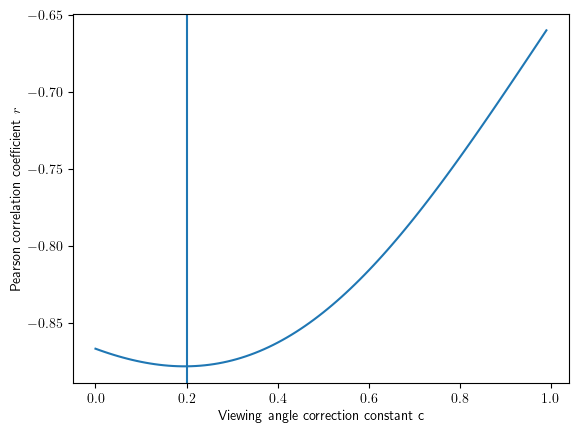

In [7]:
# Viewving angle correction
background=np.nanmedian(wic['img'].values[(wic['sza'].values>100)|(np.isnan(wic['sza'].values))])
corrs = np.arange(0,1,0.01)

from scipy.stats import pearsonr

#fig,axs=plt.subplots(1,5,figsize=(20,5))
r = []
for ii,corr in enumerate(corrs):
    wic['cimg'] = (wic['img']-background)*np.cos(np.deg2rad(wic['dza']))/np.exp(corr*(1. - 1/np.cos(np.deg2rad(wic['dza']))))
    
    r.append(pearsonr(wic['sza'].values[wic.sza>0],wic['cimg'].values[wic.sza>0])[0])
    
plt.plot(corrs,r)
plt.xlabel('Viewing angle correction constant c')
plt.ylabel('Pearson correlation coefficient $r$')
plt.axvline(corrs[np.argmin(r)])

It is also relevant to compare this method to the method described in *Ohma et al.* (2023).

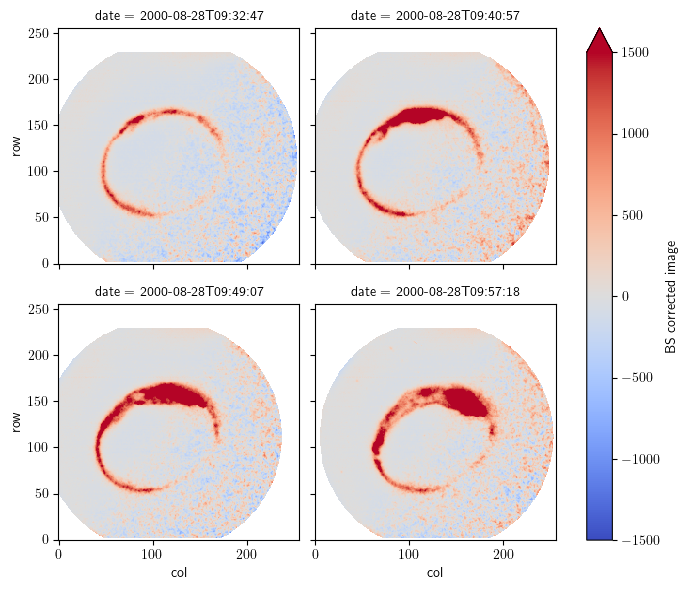

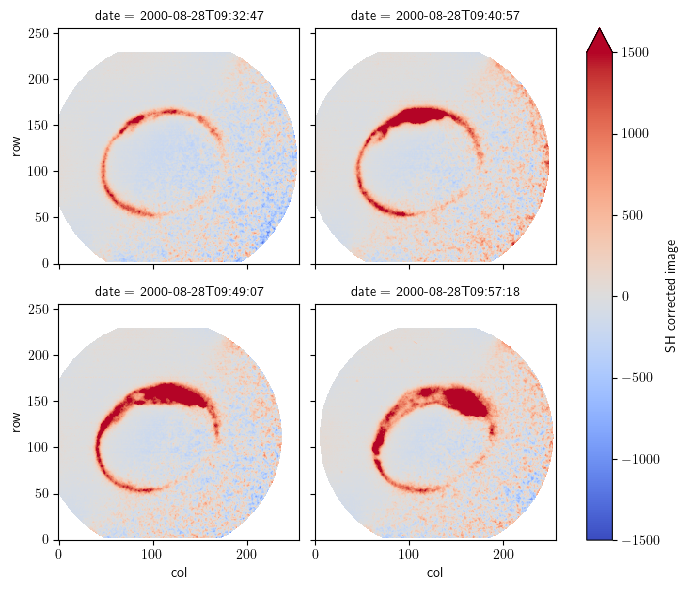

In [10]:
wic2 = wic.fuv.backgroundmodel_BS(tOrder=0).fuv.backgroundmodel_SH(4,4,tOrder=0)
wic.isel(date=[2,6,10,14])['dgimg'].plot(x='col', y='row', col='date', col_wrap=2,vmin=-1500,vmax=1500,cmap='coolwarm')
wic2.isel(date=[2,6,10,14])['shimg'].plot(x='col', y='row', col='date', col_wrap=2,vmin=-1500,vmax=1500,cmap='coolwarm')